In [184]:
from pathlib import Path
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

In [185]:
DATA_PATH = Path('')
train = pd.read_csv(DATA_PATH / 'Train.csv')
test = pd.read_csv(DATA_PATH / 'Test.csv')

# Sort data by date for rolling windows + other time-based operations
train = train.sort_values(by="date")

In [186]:
# Plotting utility functions

def plot_pm2_5_emissions_city():
    # Plotting emissions over time for each city
    for city in train["city"].unique():
        print(train[train["city"] == "Lagos"]["date"])
        city_rows = train[train["city"] == city]
        print(city, city_rows.shape)
        plt.figure(figsize=(10, 6))
        plt.plot(city_rows["date"], city_rows["pm2_5"])
        plt.title(f'PM2.5 Emissions Over Time ({city})')
        plt.xlabel('Date')
        plt.ylabel('PM2.5 Emissions')
        plt.show()


def plot_pm2_5_emissions_city_scatter():
    plt.figure(figsize=(10,6))
    for city in train['city'].unique():
        plt.scatter([city]*len(train[train['city']==city]), train[train['city']==city]['pm2_5'])
    plt.xlabel('City')
    plt.ylabel('pm2.5 Emissions')
    plt.title('pm2.5 Emissions for Each City')
    plt.xticks(rotation=90)
    plt.show()

In [187]:
print(train.columns)
print(train["city"])
print(train["city"].value_counts())

Index(['id', 'site_id', 'site_latitude', 'site_longitude', 'city', 'country',
       'date', 'hour', 'sulphurdioxide_so2_column_number_density',
       'sulphurdioxide_so2_column_number_density_amf',
       'sulphurdioxide_so2_slant_column_number_density',
       'sulphurdioxide_cloud_fraction', 'sulphurdioxide_sensor_azimuth_angle',
       'sulphurdioxide_sensor_zenith_angle',
       'sulphurdioxide_solar_azimuth_angle',
       'sulphurdioxide_solar_zenith_angle',
       'sulphurdioxide_so2_column_number_density_15km', 'month',
       'carbonmonoxide_co_column_number_density',
       'carbonmonoxide_h2o_column_number_density',
       'carbonmonoxide_cloud_height', 'carbonmonoxide_sensor_altitude',
       'carbonmonoxide_sensor_azimuth_angle',
       'carbonmonoxide_sensor_zenith_angle',
       'carbonmonoxide_solar_azimuth_angle',
       'carbonmonoxide_solar_zenith_angle',
       'nitrogendioxide_no2_column_number_density',
       'nitrogendioxide_tropospheric_no2_column_number_densi

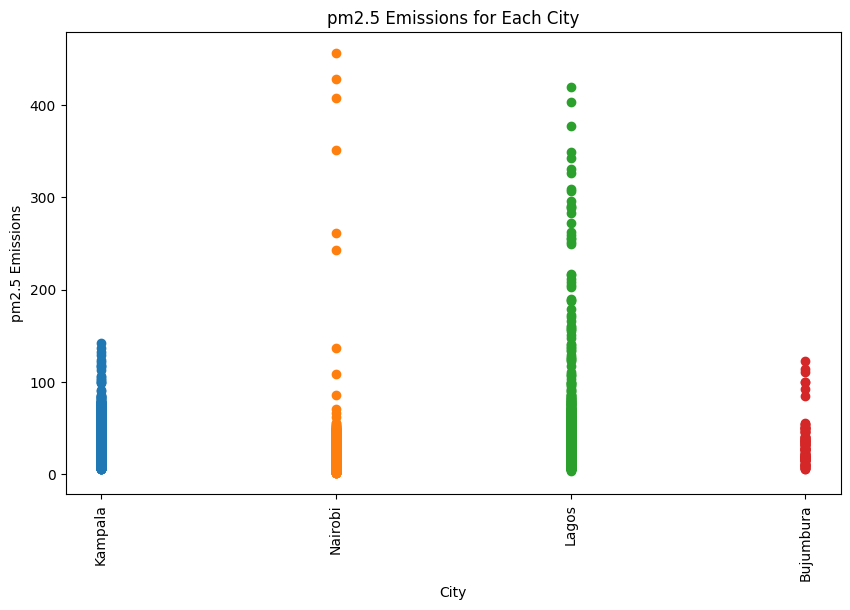

In [188]:
# Plotting pm2.5 emissions for each city (Comparison with all cities in one plot)
plot_pm2_5_emissions_city_scatter()

Lagos and Nairobi appear to have significantly more "outlier" emissions than Kampala and Bujumbura.

Simply removing them by using a threshold would not be the best as it could leave gaps in the data in terms of dates. A better approach would be to use a sliding window and attempting to detect outliers.

5513    2023-08-02
5514    2023-08-03
5515    2023-08-04
3234    2023-08-05
5516    2023-08-05
           ...    
7293    2024-01-27
997     2024-01-27
1087    2024-01-27
1128    2024-01-27
1144    2024-01-27
Name: date, Length: 852, dtype: object
Kampala (5596, 80)


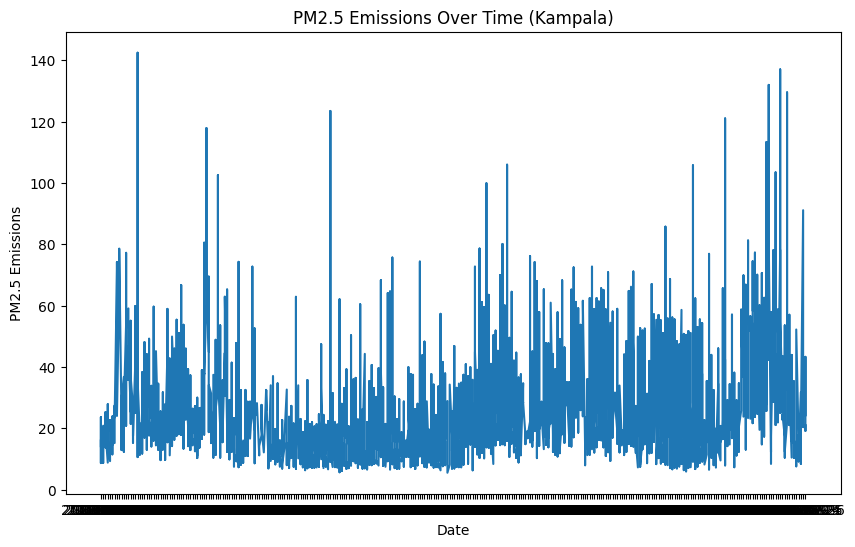

5513    2023-08-02
5514    2023-08-03
5515    2023-08-04
3234    2023-08-05
5516    2023-08-05
           ...    
7293    2024-01-27
997     2024-01-27
1087    2024-01-27
1128    2024-01-27
1144    2024-01-27
Name: date, Length: 852, dtype: object
Nairobi (1500, 80)


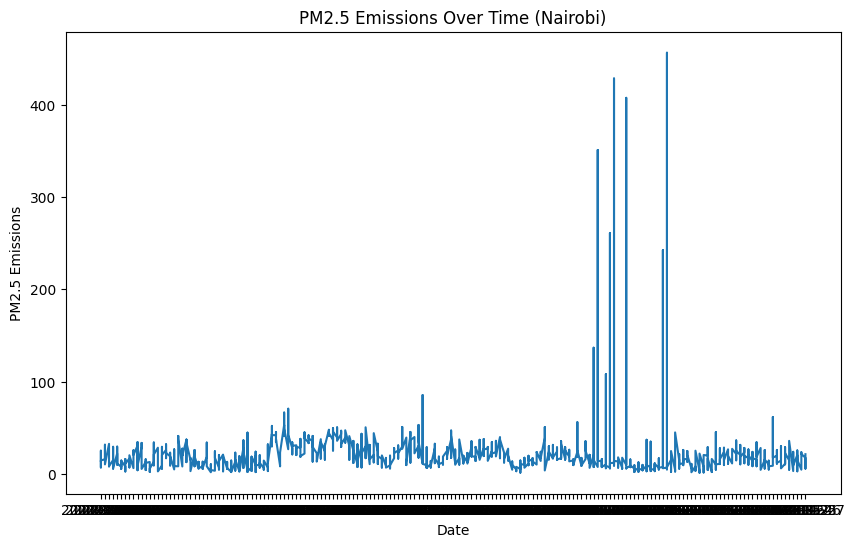

5513    2023-08-02
5514    2023-08-03
5515    2023-08-04
3234    2023-08-05
5516    2023-08-05
           ...    
7293    2024-01-27
997     2024-01-27
1087    2024-01-27
1128    2024-01-27
1144    2024-01-27
Name: date, Length: 852, dtype: object
Lagos (852, 80)


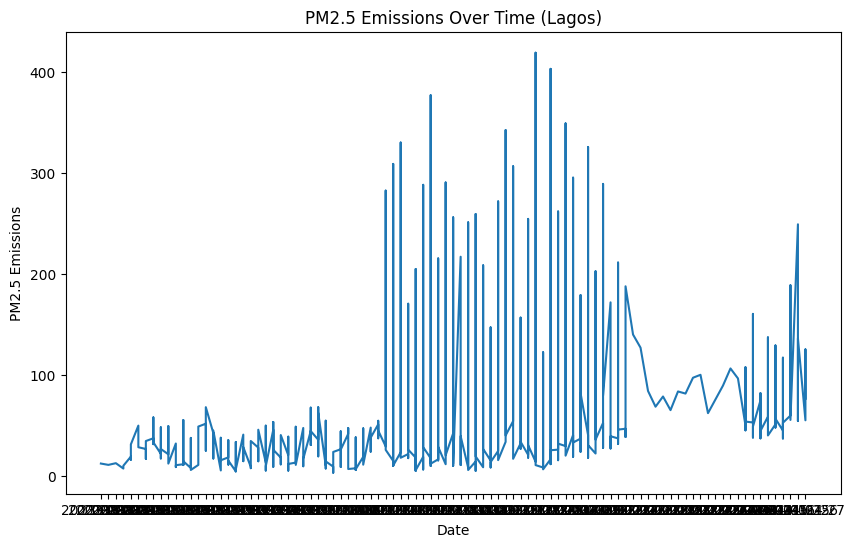

5513    2023-08-02
5514    2023-08-03
5515    2023-08-04
3234    2023-08-05
5516    2023-08-05
           ...    
7293    2024-01-27
997     2024-01-27
1087    2024-01-27
1128    2024-01-27
1144    2024-01-27
Name: date, Length: 852, dtype: object
Bujumbura (123, 80)


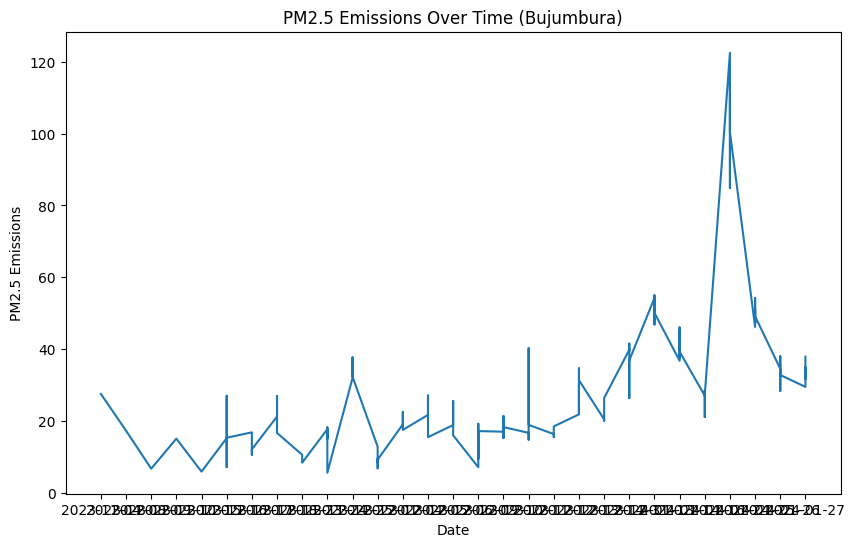

In [189]:
# Plotting pm2.5 emissions for each city
plot_pm2_5_emissions_city()

Clearly, some cities have more outliers than others. For example, the city of Lagos has a lot of outliers in the pm2.5 emissions.
Cities like Lagos and Nairobi should have handling for outliers.

In [190]:
for city in train["city"].unique():
    city_rows = train[train["city"] == city]
    std = city_rows["pm2_5"].std()
    median = city_rows["pm2_5"].median()
    mean = city_rows["pm2_5"].mean()
    print(f"City: {city} | Pm2.5 median| {median} | Pm2.5 mean | {mean} | Pm2.5 Std {std}")

City: Kampala | Pm2.5 median| 18.13490000000001 | Pm2.5 mean | 22.765383909098915 | Pm2.5 Std 14.34682858151784
City: Nairobi | Pm2.5 median| 15.275129411764706 | Pm2.5 mean | 18.87932986637841 | Pm2.5 Std 24.982218437683237
City: Lagos | Pm2.5 median| 33.43527307692308 | Pm2.5 mean | 46.213293731406935 | Pm2.5 Std 52.84388334184577
City: Bujumbura | Pm2.5 median| 26.352000000000004 | Pm2.5 mean | 30.69875772769944 | Pm2.5 Std 22.35338406057941


In [191]:
# Removing outliers for Lagos and Nairobi
window_size = 20
threshold = 10

# Function to calculate rolling average and finding outliers
def is_outlier(value, rolling_mean, rolling_std):
    if np.isnan(rolling_mean):
        return False
    threshold = 2 * rolling_std # 2 standard deviations
    return abs(value - rolling_mean) > threshold

def rolling_window_stats(data, window_size):
    rolling_mean = data.rolling(window=window_size).mean()
    rolling_std = data.rolling(window=window_size).std()
    return rolling_mean, rolling_std

# Finding indexes of all outliers
indexes = []
for city in ["Lagos", "Nairobi"]:
    city_data = train[train["city"] == city]
    rolling_means, rolling_stds = rolling_window_stats(city_data["pm2_5"], window_size)
    outliers = city_data.apply(lambda row: is_outlier(row["pm2_5"], rolling_means[row.name], rolling_stds[row.name]),axis=1)
    indexes.extend(outliers[outliers == True].index)
    print("City", city, outliers[outliers == True].shape[0])
    print()

    print(city_data[outliers == True]["pm2_5"])

print("Before", train.shape)
train = train.drop(index=indexes)
print("After", train.shape)

City Lagos 33

3170     54.731200
4432    282.816800
4433    309.273462
4434    330.450000
4435    170.728846
4436    205.100000
4437    288.566154
4438    377.314375
4439    215.588077
4440    290.868800
4441    256.306731
4442    217.304107
4443    251.340400
4444    259.572000
4445    208.726071
4447    189.768214
7       272.091429
4448    342.757308
4449    306.901800
4451    254.786923
4452    419.481190
4454    403.490000
4455    262.130962
4456    349.405185
4457    295.671964
4459    326.044750
20      202.870400
21      289.464038
4463    211.526429
24      188.006000
31      189.000179
32      249.443696
1086    136.400000
Name: pm2_5, dtype: float64
City Nairobi 51

7148     33.841667
7790     36.316344
7330     44.621865
7335     31.841843
7336     43.278442
7797     29.768271
3427     44.708000
7981     48.379000
5329     41.391333
66       35.768333
7164     51.926000
7481     41.925101
7982     41.820000
7337     42.332444
7798     34.526460
7482     39.800737
5728     

5513    2023-08-02
5514    2023-08-03
5515    2023-08-04
3234    2023-08-05
5516    2023-08-05
           ...    
7293    2024-01-27
997     2024-01-27
1087    2024-01-27
1128    2024-01-27
1144    2024-01-27
Name: date, Length: 819, dtype: object
Kampala (5596, 80)


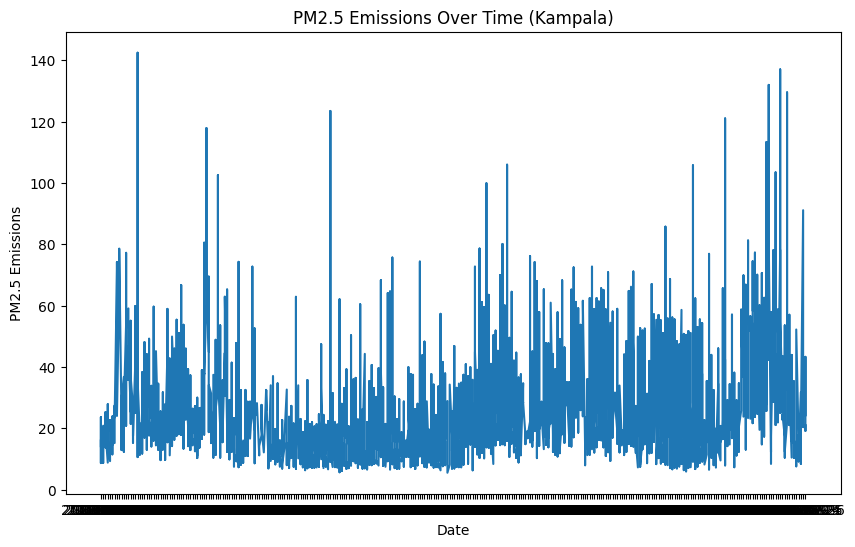

5513    2023-08-02
5514    2023-08-03
5515    2023-08-04
3234    2023-08-05
5516    2023-08-05
           ...    
7293    2024-01-27
997     2024-01-27
1087    2024-01-27
1128    2024-01-27
1144    2024-01-27
Name: date, Length: 819, dtype: object
Nairobi (1449, 80)


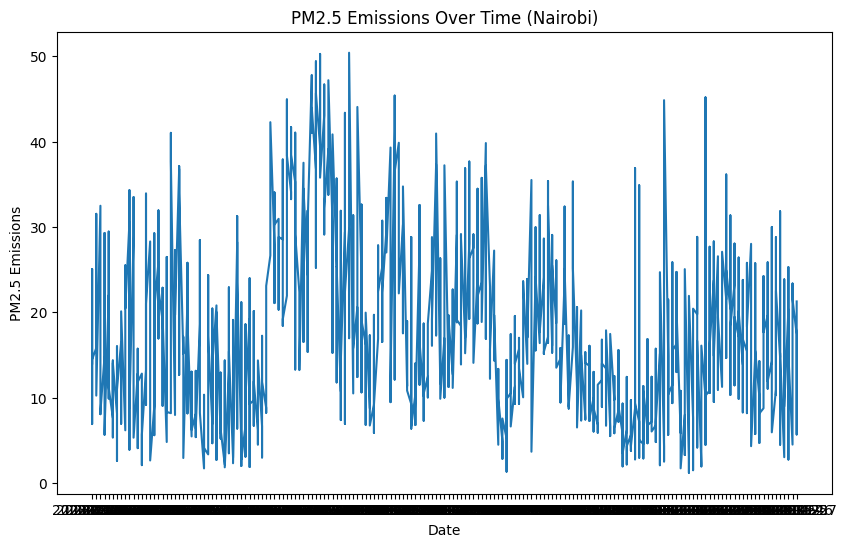

5513    2023-08-02
5514    2023-08-03
5515    2023-08-04
3234    2023-08-05
5516    2023-08-05
           ...    
7293    2024-01-27
997     2024-01-27
1087    2024-01-27
1128    2024-01-27
1144    2024-01-27
Name: date, Length: 819, dtype: object
Lagos (819, 80)


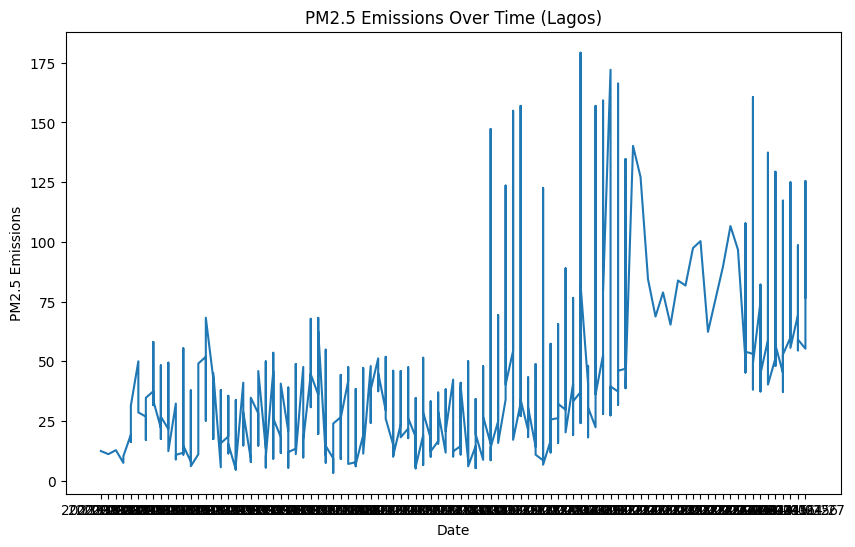

5513    2023-08-02
5514    2023-08-03
5515    2023-08-04
3234    2023-08-05
5516    2023-08-05
           ...    
7293    2024-01-27
997     2024-01-27
1087    2024-01-27
1128    2024-01-27
1144    2024-01-27
Name: date, Length: 819, dtype: object
Bujumbura (123, 80)


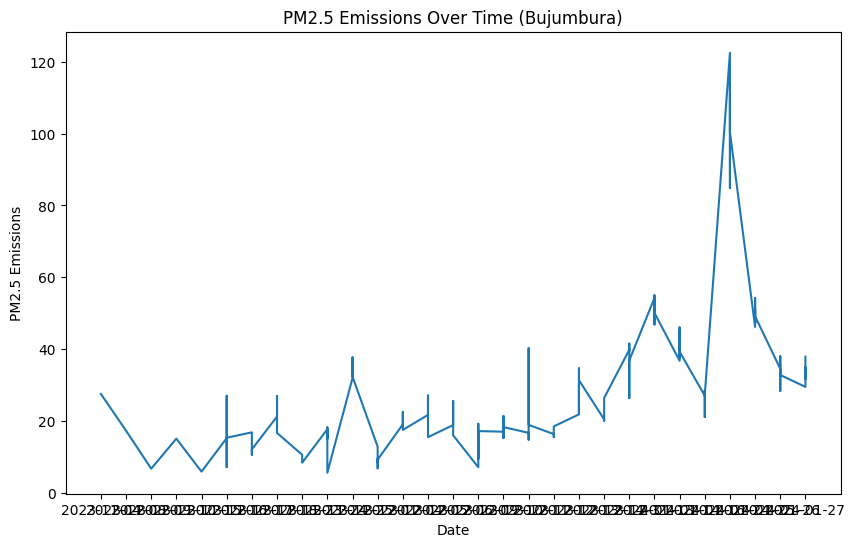

In [192]:
# Plotting emissions over time for each city after removing outliers
plot_pm2_5_emissions_city()

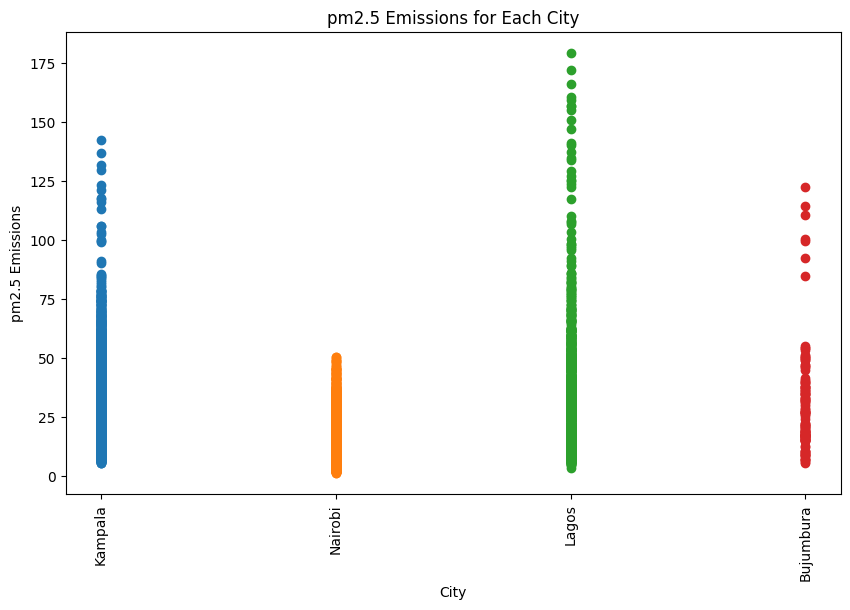

In [193]:
# Scatter plot after processing
plot_pm2_5_emissions_city_scatter()